<a href="https://colab.research.google.com/github/wallisonferreira/data-science-tce/blob/main/7_MLP_com_regress%C3%A3o_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exemplo de MLP com Regressão

Dataset: Brazilian Houses to Rent (https://www.kaggle.com/datasets/rubenssjr/brasilian-houses-to-rent)

In [1]:
!pip install livelossplot

In [2]:
#imports
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

#sklea
import sklearn as sk
from sklearn.model_selection import train_test_split

#utils
import random
import seaborn as sn
from livelossplot import PlotLossesKeras
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

#Dataset e pré-processamento

In [3]:
import pandas as pd
data = pd.read_csv('houses_to_rent_v2.csv')
data.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11,836


In [4]:
#target = total(R$)
y = data['total (R$)']


#converter variáveis nominais para número - city, animal, furniture
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize

def preProcess(features):
  encoder = LabelEncoder()
  campos = pd.DataFrame(encoder.fit_transform(features))
  return campos

data['city_enc'] = preProcess(data[['city']])
data['animal_enc'] = preProcess(data[['animal']])
data['furniture_enc'] = preProcess(data[['furniture']])

#remover campos desnecessários
data = data.drop(columns=['city', 'animal', 'furniture', 'total (R$)'])
data = data.fillna(0) #nulos devem virar zero
df = data.replace('-', '0') #valor encontrado em floor
data.head()

#normalizar os valores
X = normalize(df.to_numpy(), axis = 0)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<ipython-input-5-8447447ab6bd>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrMatrix = data.corr().round(2)


<Axes: >

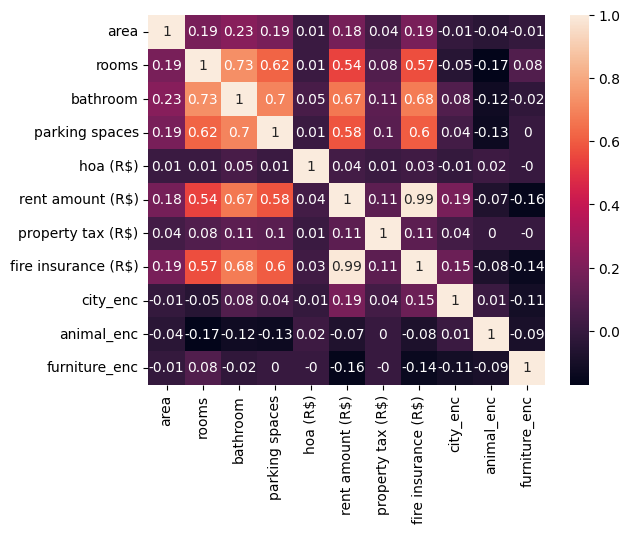

In [5]:
#Correlação entre variáveis
corrMatrix = data.corr().round(2)
sn.heatmap(corrMatrix, annot=True)

#Definição de um modelo

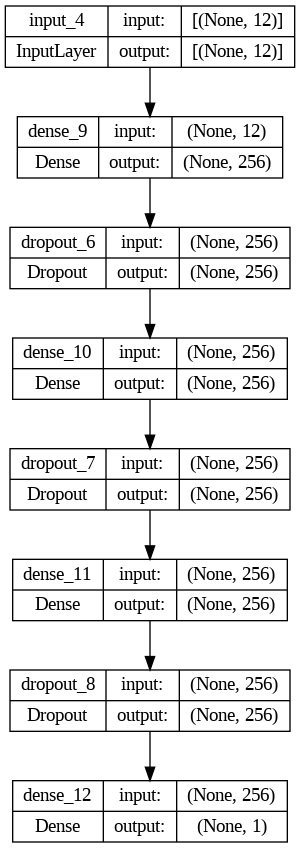

In [9]:
def construirModelo(input_shape):
  model = keras.Sequential(
      [layers.Input(shape= input_shape),
       layers.Dense(256, activation='relu'),
       #layers.BatchNormalization(),
       #layers.Activation(activation='relu'),
       layers.Dropout(0.2),
       layers.Dense(256, activation='relu'),
       layers.Dropout(0.2),
       layers.Dense(256, activation='relu'), # aumentando mais
       layers.Dropout(0.2),                  # uma camada
       layers.Dense(1, activation='relu') #ativação linear, o valor é um número positivo
      ]
  )

  model.compile(optimizer="adam",
                loss="mape", #https://keras.io/api/metrics/regression_metrics/#meanabsolutepercentageerror-class
                metrics=["mae"]) #https://keras.io/api/metrics/regression_metrics/#meanabsoluteerror-class
  return model

model = construirModelo(X.shape[1])
plot_model(model, show_shapes=True)

#Experimento

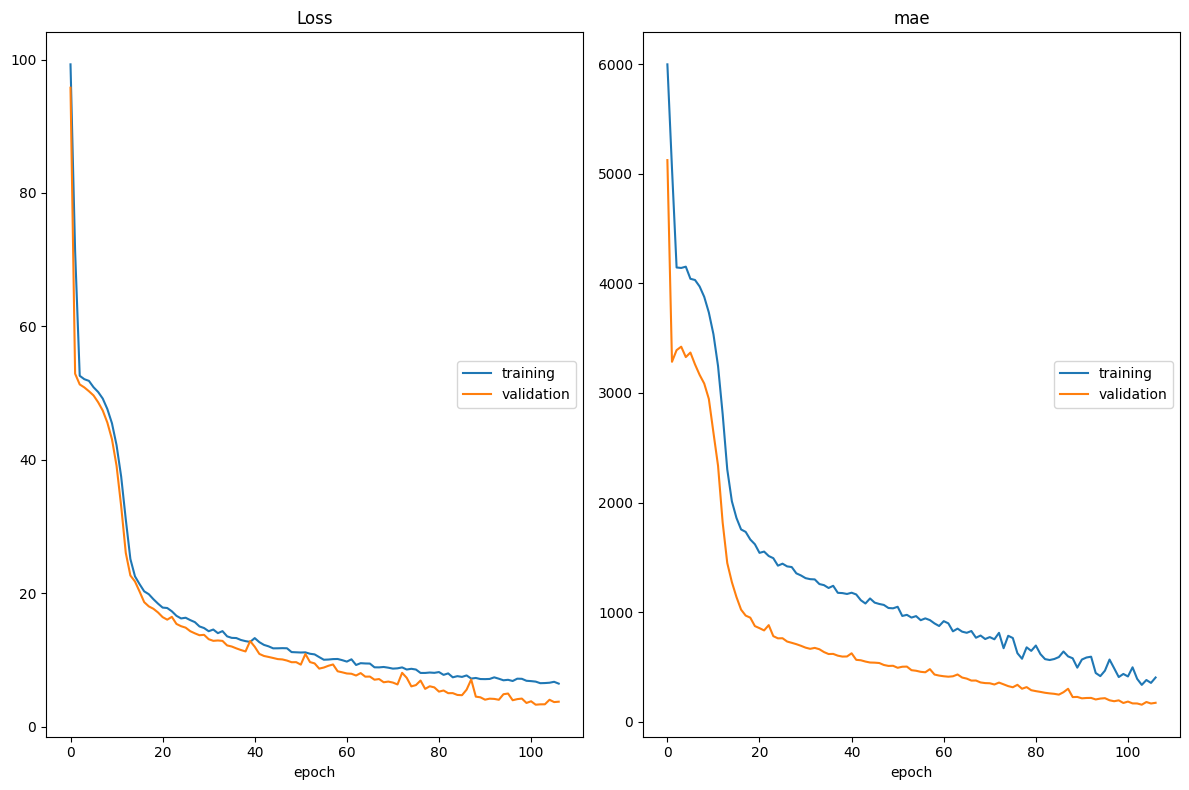

Loss
	training         	 (min:    6.432, max:   99.279, cur:    6.432)
	validation       	 (min:    3.271, max:   95.780, cur:    3.721)
mae
	training         	 (min:  336.288, max: 5997.000, cur:  403.653)
	validation       	 (min:  155.492, max: 5123.458, cur:  172.882)
54/54 [==============================] - 1s 26ms/step - loss: 6.4316 - mae: 403.6526 - val_loss: 3.7209 - val_mae: 172.8819
MAPE: 3.2873446941375732 +- 0.0
MAE: 302.4947204589844 +- 0.0


In [14]:
n_runs = 1 #número de execuções
perc_treino = 0.8
batch_size = 32 #anterior: 16
epochs = 150

mape_list = []
mae_list = []

for i in range(n_runs):

  #pre-requisito
  model = construirModelo(X.shape[1])

  #a) divide a base aleatoriamente
  x_train, x_test, y_train, y_test = train_test_split(X, y,
                                                      train_size=perc_treino,
                                                      random_state = random.randint(1, 1000))
  x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,
                                                      train_size=0.2, #20% para validação
                                                      random_state = random.randint(1, 1000))

  # parar antes do tempo, se necessário
  early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

  #b) treina
  H = model.fit(
      x_train,
      y_train,
      batch_size= batch_size,
      epochs = epochs,
      callbacks=[PlotLossesKeras(), early], #plotando gráficos
      validation_data = (x_val, y_val))

  #c) predição
  mape, mae = model.evaluate(x=x_test, y=y_test, batch_size=batch_size, verbose=0)


  #d) acumula resultados
  mape_list.append(mape)
  mae_list.append(mae)

#calculando as médias das execuções
mape_media = np.asarray(mape_list).mean(axis=0)
mae_media = np.asarray(mae_list).mean(axis=0)

#calculando os desvios das execuções
mape_std = np.asarray(mape_list).std(axis=0)
mae_std = np.asarray(mae_list).std(axis=0)

print ("MAPE: " + str(mape_media) + " +- " + str(mape_std))
print ("MAE: " + str(mae_media) + " +- " + str(mae_std))



##Visualizando alguns resultados

67/67 [==============================] - 0s 2ms/step


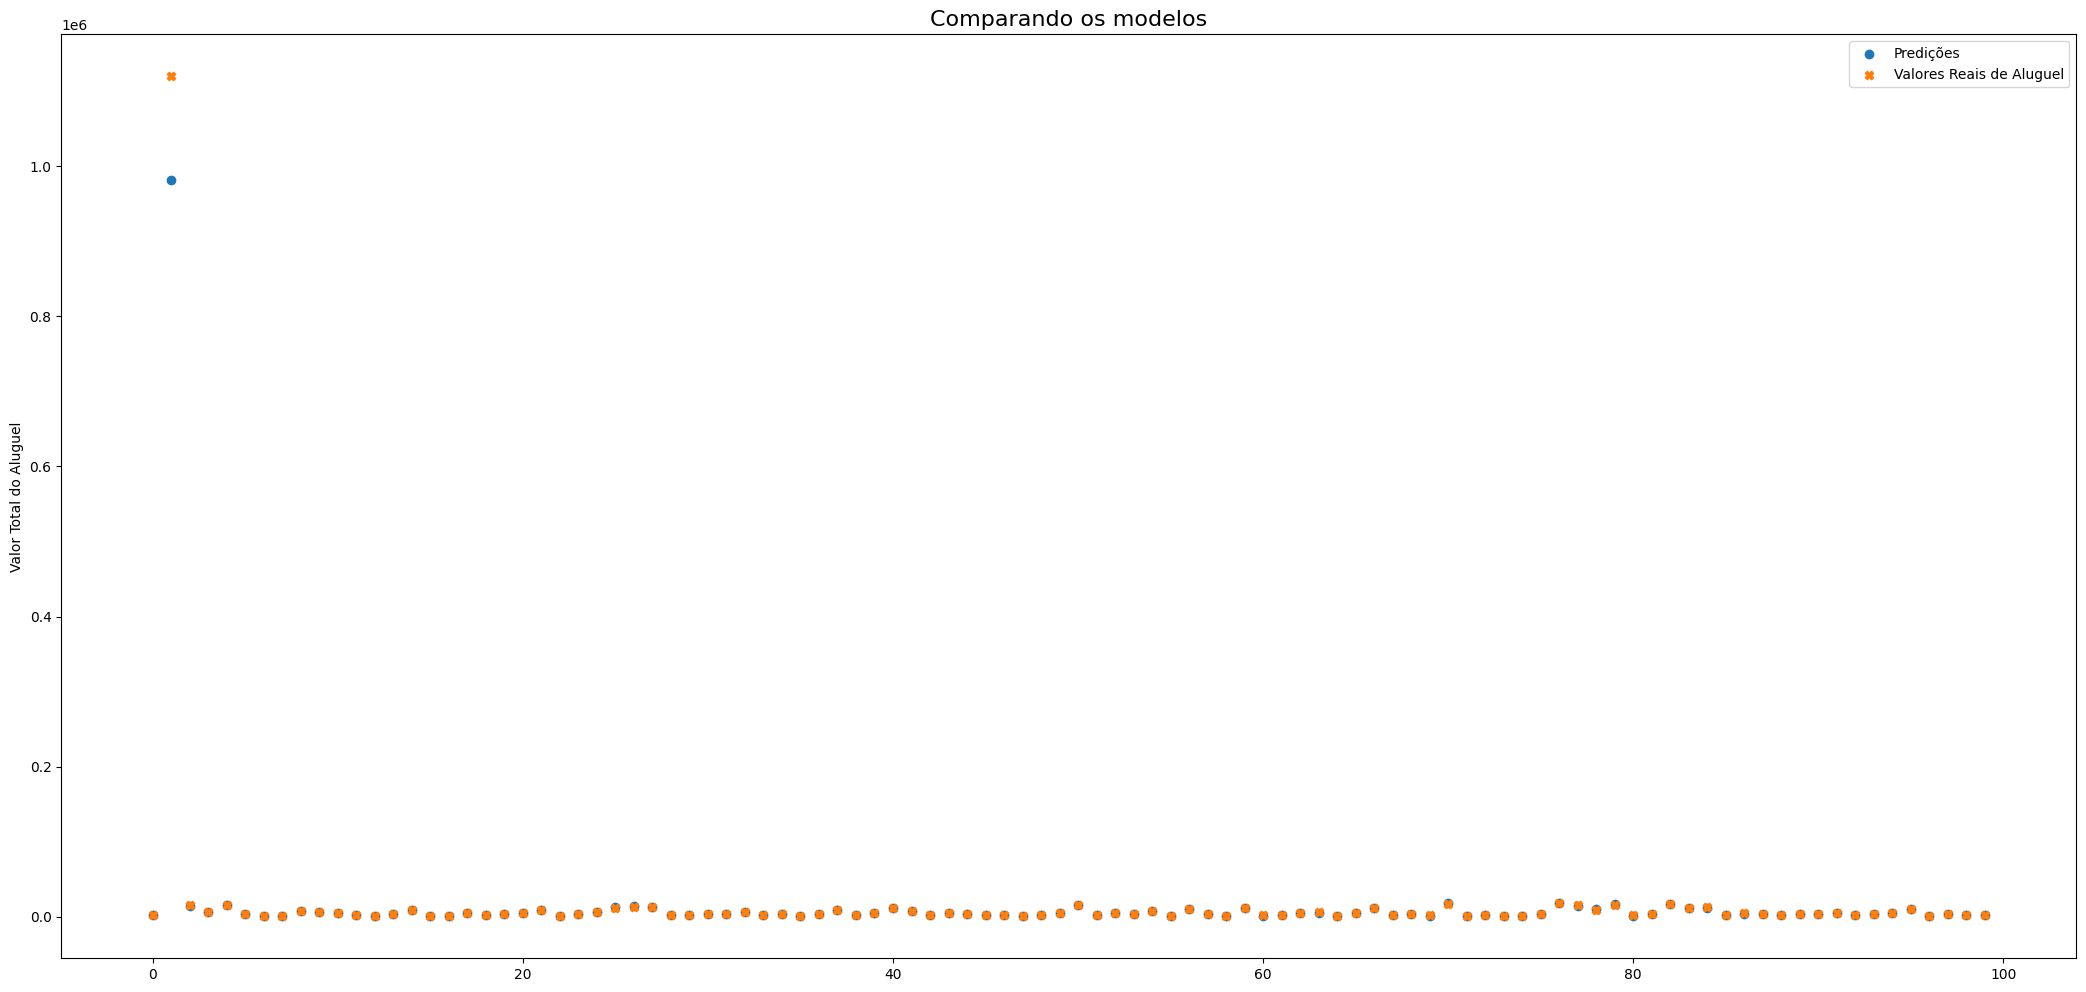

In [15]:
predictions = model.predict(x_test)

x_values = list(range(len(y_test[:100])))

plt.figure(figsize=(26,12))
plt.scatter(x_values, predictions[:100], label="Predições")
plt.scatter(x_values, y_test[:100], marker="X",label="Valores Reais de Aluguel")

plt.legend(loc="best")
plt.title("Comparando os modelos", fontsize=16)
plt.ylabel("Valor Total do Aluguel")
plt.show()
